<a href="https://colab.research.google.com/github/gdeiss/abalone/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sklearn Tutorial: Cross-validation for Different Datasets and Models

With big data and artificial intelligence being the buzzwords they are, there should be very few people reading this who aren't aware that there's a lot of data out there. Thanks to the technology now available to us, data is more accessible than ever. Besides the daunting surplus of data, there's a staggering amount of statisticians and data scientists out there trying to make something of it all. Sometimes, they're even successful!

Modeling data is no easy task, and mistakes are bound to be made along the way. Even after engineering features and fine-tuning the hyperparameters for a model, it's easy to overfit or underfit to the data. Overfitting is the act of listening too much to noise in a dataset, such that the simpler, general trend isn't properly represented; underfitting is the act of not listening quite enough to the point that the model doesn't really represent the underlying trend.

How can we avoid these obstacles? Cross-validation. Cross-validation is the practice of setting aside a subset of the data, called the *training data* with which to train the model; then, once training is completed, evaluating the model's performance on the remaining data, called the *validation set* (or sets). 

However, there are many different ways to go about doing this. In this tutorial, we will go in-depth on the many variants of cross-validation, describing the benefits and drawbacks of each one, and the circumstances that determine when they should be performed. And we will go over example code that shows how to succintly perform each type of cross-validation using the sklearn python library.

We'll start with outlining overfitting vs. underfitting, then go into holdout validation to reinforce general concepts. Since this has been covered in homework, we'll spend more time on k-fold validation and its more advanced variant, stratified k-fold validation. We'll also use a few of sklearn's built-in modeling techniques, including a linear regression model, kNN, and a simple neural network.

# Tutorial Content

In this tutorial, we'll be demonstrating how to perform some of the most popular forms of cross-validation easily using sklearn. We'll start with a brief refresher on overfitting and underfitting, then perform holdout validation from scratch to reinforce the general mechanism to perform cross-validation. From there, we'll learn more advanced techniques of cross-validation, and learn how to do them easily at that via sklearn. We'll also show off some of sklearn's many modeling techniques, from linear regression, to k-nearest neighbors, to neural networks. We'll end with 

# Overfitting and Underfitting
Most should be familiar with what overfitting and underfitting are, but we'll start with a brief refresher since they are the very reason we cross-validate. We'll generate a dataset of points along a simple sin wave, with some random noise thrown in.

Text(0.5, 1.0, 'Figure 1: Sin Function with Noise')

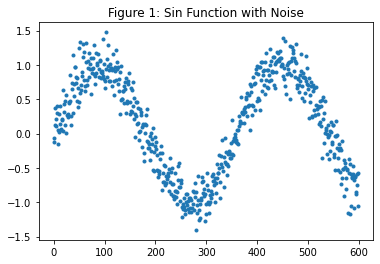

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import *

X = range(600)
X = np.asarray(X)

y = np.asarray(list(np.sin(np.pi / 180. * i) for i in X))
y.shape = (600, 1)

for i in X:
    y[i] += gauss(0, .2)

plt.plot(X, y, '.')
plt.title("Figure 1: Sin Function with Noise")

Perfect. Now we'll try to find a model to fit this function. For simplicity, we'll be fitting a linear regression model, but adjusting the hyperparameter of degrees (i.e. the degree of the polynomial). We'll fit 3 polynomial regression models over our dataset, selecting the hyperparameter of degrees to be different for each: the first will be of degree 1, the second of degree 6, and the final of degree 12.

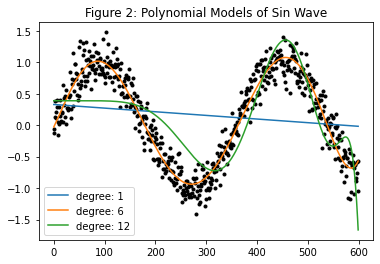

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

plt.plot(X, y, '.', color='black')
plt.title("Figure 2: Polynomial Models of Sin Wave")

degrees = [1, 6, 12]

for d in degrees:
    poly_features = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly_features.fit_transform(X.reshape(-1, 1))
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)

    poly_predict = poly_reg.predict(X_poly)

    plt.plot(X, poly_predict, label = "degree: " + str(d))
    plt.legend(loc="best")

We see that our model with degree 1 is nothing more than a linear line of best fit. It doesn't learn anything about the ups-and-downs in y values that we can easily see with our human eye. Meanwhile, Our model of degree 12 also makes troubling choices in how to fit to the data, clearly listening too much to noise in the data. Our model of degree 5 is the only one that seems to be in the right ballpark of estimating the true regression function.

# Cross-Validation: The Big Picture

It's easy to see in the above example that a degree of 6 makes for the best model. Unfortunately, with real-world data, patterns are generally much tougher to see than in this contrived example. We can't always rely on human intuition to choose a hyperparameter like we did above. Thus, we need a mathematical way of evaluating the performace of a model. This is the purpose of Cross-Validation.

Cross-validation consists of 2 steps:

1. Training your model on a subset of your data, with hyperparameters chosen heuristically
2. Evaluating it's performance on the data not used (validation set). Record it's error rate
3. Repeating from step one with new hyperparemeters

Steps 1-3 are repeated for as many different values for hyperparameters the data scientist desires. Once done, the hyperparameters which yielded the lowest error rate are settled upon. [note: what "error rate" is depends on the type of problem. For regression, we use MSE; in classification, proportion of incorrect predictions; etc.]

However, step 2 leaves room for interpretation on what exactly subsetting our data entails. There are many ways of going about doing this, which ultimately yields the many different "subgenres" of cross-validation. We'll go over them in detail now.


# Types of Cross Validation
Frankly, the differences between the different varieties of cross-validation aren't drastic. There are pros and cons of each, often coming down to differences in computational complexity, or trading off bias for variance in which model is deemed best. 

However, any professional data scientist should still be familiar with each technique, as these subtleties can cause massive differences in the performance of a model -- especially in the case of time series and imbalanced datasets. Say you have temporal data from 2010-2020; further, say that data collection picked up halfway through the decade, such that 80% of your data is from 2015 onward. In this case, the difference between a model crafted with cross-validation accounting for this vs. one that doesn't could be massive, given that the data may not be independent of they year it was collected in. 

With this in mind, let's clarify the differences between some of the most popular techniques of cross-validation, starting with the simplest.

## Holdout Cross Validation
This method for cross validation is perhaps the easiest to understand, but also the most naive. In this variant, we train our model on the bulk of the data (say, 80%) and validate it on the rest. 

We'll continue using the sine-wave data (for now). Recall that we have x values stretching from 0 to 600, and corresponding y-values with a bit of noise. To perform this form of cross-validation, we will:

1. Randomly pick 480 (x, y) pairs (80% of our dataset) to comprise our trainset, leaving the rest for validation
2. Train a model of degree 1 on the train set
3. Using the model, make predictions on the validation set. Compare to the actual value to calculate MSE
4. Repeat from step 2 up to a degree of 20
5. Once done, pick the degree that yielded the lowest MSE

Once done, we'll plot the MSE against the degree of the polynomial. We use the sklearn method train_test_split to easily make a random split of our data.

In [3]:
def squared_error(y_pred, y):
    # Utility function to compute squared error
    l = []
    for i in range(len(y_pred)):
        l.append((y_pred[i] - y[i])**2)
    return sum(l) / len(l)

Text(0.5, 1.0, 'Figure 2: MSE vs. Degree of Model')

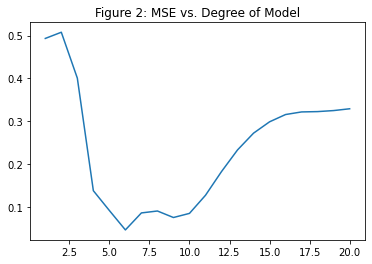

In [4]:
import sklearn
from sklearn.model_selection import *

# Build train & validation sets
trainX, valX, trainY, valY = sklearn.model_selection.train_test_split(X, y, train_size=480)

# A list of degrees from 1 to 20
degrees = [i for i in range(1, 21)]

# Empty list that we'll store the MSE of each model in
mses = []

for d in degrees:
    poly_features = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly_features.fit_transform(trainX.reshape(-1, 1))
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, trainY)
   
    X_poly_val = poly_features.transform(valX.reshape(-1, 1))
    poly_predict = poly_reg.predict(X_poly_val)
    mses.append(squared_error(poly_predict, valY)[0])
    
plt.plot(degrees, mses)
plt.title("Figure 2: MSE vs. Degree of Model")

We see that the degree 6 model yields the lowest MSE. MSE starts very high at degrees from about 1 to 4. This is where our model is *underfitting*. It achieves more or less equally good values from 5-10, then begins to rise again. Beyond degree of 10 is where we *overfit*.

Holdout validation is quite simple, which is both a good appeal and a glaring weakpoint of it. Specifically, it's pros and cons are:

#### Pros
- Computationally Efficient (Good for Large Datasets)
- Works fine if you know your dataset is well-balanced and simple

#### Cons
- Since there's only a single split of training vs. validation data, this form of cross-validation is subject to randomness in initial split
- Bad for unbalanced datasets

In short, holdout validation is never the best choice for producing the best model possible. But if you know for a certainty that you have a very clean, simple dataset; or perhaps if you're in the initial stages of modeling a massive dataset and just want something that's good enough for the time being, it works great.

# k-fold Cross-Validation

K-fold cross validation is arguably the most popular form of cross-validation, and for most datasets it works great. Recall that the biggest problem with holdout validation is that it's quite subject to randomness since you only have a single training set and a single test set.

K-fold cross validation circumvents this by effectively performing holdout validation *k* times. It subsets the data once into a train and test set; then it does it again, **making sure no values from the previous test set make it in again**; and so on, *k* times total.

Let's perform k-fold cross validation. From here on we'll be making more extensive use of sk_learn's capabilities since the underlying mechanism for cross-validation has been fully established.

Let's also move onto a less contrived dataset, and move beyond linear regression. Let's load a dataset on abalone (a type of shellfish) and try to predict its age from its logarithmically-transformed Length, Diameter, and Height. Note that it's age is recorded in a variable called "rings", as the rings on the abalone correspond to its age. We start by just loading the data and transforming the relevant columns.

In [13]:
from sklearn.model_selection import KFold
import pandas as pd

data = pd.read_csv('abalonemt.csv')

data["Length"] = np.log(data["Length"])
data["Diameter"] = np.log(data["Diameter"])
data["Height"] = np.log(data["Height"])

X = data[["Length", "Diameter", "Height"]]
X = np.asarray(X)
y = np.asarray(data["Rings"])

                                                     Sex  ... Rings
0                                        <!DOCTYPE html>  ...   NaN
1                                      <html lang="en" >  ...   NaN
2                                                 <head>  ...   NaN
3                                 <meta charset="utf-8">  ...   NaN
4        <link rel="dns-prefetch" href="https://githu...  ...   NaN
...                                                  ...  ...   ...
50950    <div class="Popover-message Popover-message-...  ...   NaN
50951                                             </div>  ...   NaN
50952                                             </div>  ...   NaN
50953                                            </body>  ...   NaN
50954                                            </html>  ...   NaN

[50955 rows x 9 columns]


TypeError: ignored

Now we move on to actually performing k-fold cross validation.

Text(0.5, 1.0, 'Figure 3: MSE vs. Degree of Model')

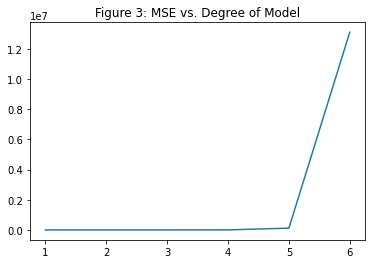

In [ ]:
kf = KFold(n_splits=5)

degrees = [i for i in range(1, 7)]
mses = []

for d in degrees:
    kmses = []
    for train_index, test_index in kf.split(X):
        trainX, valX = X[train_index], X[test_index]
        trainY, valY = y[train_index], y[test_index]
        
        poly_features = PolynomialFeatures(degree=d, include_bias=False)
        X_poly = poly_features.fit_transform(trainX)
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly, trainY)

        X_poly_val = poly_features.transform(valX)
        poly_predict = poly_reg.predict(X_poly_val)
        kmses.append(squared_error(poly_predict, valY))
    # kmses contains the mse for each split, k. Take the mean of this and append it to mses.
    mses.append(sum(kmses) / len(kmses))

plt.plot(degrees, mses)
plt.title("Figure 3: MSE vs. Degree of Model")

We see here that simpler seems to be better. Our model's MSE stays about equally low for degrees 1-5, then skyrockets. Now let's go over the pros and cons of our dataset, and describe why it's often viewed as the bread and butter validation technique.

#### Pros
- Computationally Efficient -- barely slower than holdout validation (since it's holdout validation performed k-times
- More consistent than holdout validation

#### Cons
- Bad for unbalanced datasets

So k-fold validation is only marginally slower than holdout validation, but gives you safer results. Note that the choice of k is more or less arbitrary, with 5 and 10 being popular choices.

If k is equal to the number of entries in the dataset, we have a special subset of k-fold validation called *leave on out validation*. Here, our validation set is a single entry. This is computationally quite expensive, but has been shown to pick the least biased model. It's thus only recommended for very small datasets, or when performance is critical.

# Stratified k-fold 

Both techniques introduced thus far have been bad for unbalanced datasets. Say, for example, we want to predict political party from a series of factors such as age, gender, religious affiliation, etc. But say our dataset is comprised of 90% republicans (perhaps we accidentally sampled only Oklahomans). We might end up making very bad predictions for the few democrats there are since there are so few of them. This problem get's even more tangled when we have more than 2 classes we're trying to predict. What if we have 200? Many classes could end up entirely absent from our training sets. This is a possibility for some models.

The solution to this problem is to make sure that in all of our training sets, the proportions between classes stay about constant. This is exactly what stratified k-fold cross validation does. 

Let's adapt our abalone dataset for a classification problem. We want to classify the clams (BARS) as young, middle-aged, or old based on the number of rings it has. Look at the histogram below to get an idea of the distribution of "ages".

(array([  17.,  430., 1646., 1387.,  329.,  228.,  100.,   29.,    4.,
           3.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

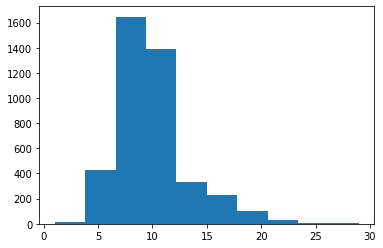

In [ ]:
plt.hist(data['Rings'])

We'll say a clam is young if it has fewer than 6 rings, and old if it has greater than 15. Note that this creates a badly unbalanced dataset; almost all of our clams are "middle-aged".

Let's add a column based on the criteria laid out above. We'll have a numerical column where 0 corresponds to young, 1 to middle-aged, and 2 to old.

In [ ]:
data['ageClass'] = 1
data.loc[data.Rings > 15, "ageClass"] = 2
data.loc[data.Rings < 6, "ageClass"] = 0

## K-Nearest Neighbors Cross-validation

Now rather than regressing to predict the number of rings a clam has, our goal has shifted to classification. This means that rather than evaluating MSE, we'll evaluate our models based on their proportion of correct vs. incorrect predictions.

As for what model we want to use, sklearn has many options for classification. k-nearest neighbors, decision trees, and neural networks are all good options. Let's start with k-nearest neighbors. We'll train a knn model tuning the parameter of how many neighbors is best. We'll cross validate using k-folds and stratified k-folds, and compare the results.

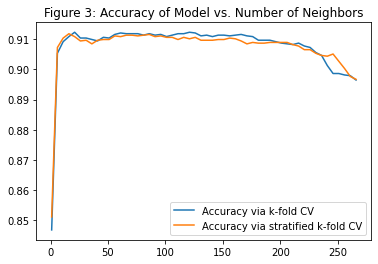

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X = data[["Length", "Diameter", "Height"]]
X = np.asarray(X)
y = np.asarray(data["ageClass"])

neighbors = [i for i in range(1, 270, 5)]
stratifiedClassificationRate = []
errorRate = []

skf = StratifiedKFold(n_splits=5)
kf = KFold(n_splits=5)

for n in neighbors:
    # Cross-validate using stratified k-folds
    kErrors = []
    for train_index, test_index in skf.split(X, y):
        trainX, valX = X[train_index], X[test_index]
        trainY, valY = y[train_index], y[test_index]
        
        knn = KNeighborsClassifier(n_neighbors=n)

        knn.fit(trainX, trainY)
        y_pred = knn.predict(valX)
        errorRate = metrics.accuracy_score(valY, y_pred)
        kErrors.append(errorRate)
    # kmses contains the mse for each split, k. Take the mean of this and append it to mses.
    stratifiedClassificationRate.append(sum(kErrors) / len(kErrors))
    
    # Cross-validate using normal k-folds
    kErrors = []
    for train_index, test_index in kf.split(X, y):
        trainX, valX = X[train_index], X[test_index]
        trainY, valY = y[train_index], y[test_index]
        
        knn = KNeighborsClassifier(n_neighbors=n)

        knn.fit(trainX, trainY)
        y_pred = knn.predict(valX)
        errorRate = metrics.accuracy_score(valY, y_pred)
        kErrors.append(errorRate)
    errorRate.append(sum(kErrors) / len(kErrors))
    

plt.plot(neighbors, errorRate, label="Accuracy via k-fold CV")
plt.plot(neighbors, stratifiedClassificationRate, label="Accuracy via stratified k-fold CV")
plt.title("Figure 3: Accuracy of Model vs. Number of Neighbors")
plt.legend(loc="best")

Here we see that as our number of neighbors increases, the accuracy of our model rapidly rises, then plateus for quite a bit before finally beginning to dip at around 180 neighbors. We also indeed see different values for the different cross-validation techniques, though the curves are approximately similar.

## Neural Networks

For k-nearest neighbors, there's only a single hyperparameter we are tuning. And as seen in the graph above, a wide range of values produces near equally-good results. But there are more complex modeling techniques out there with more hyperparameters, hyperparameters that can have much more pronounced effects on our models efficacy. Neural networks, for example, can take a lot of work to properly tune. 

Neural Networks are one of the most widely used tools in the repertoire of data scientists and machine learning engineers, and they themselves warrant their own tutorial, but we'll cover a very simple (perhaps overly simple) example here. We'll continue using the abalone dataset, tuning the number of nodes in our first hidden layer as a hyperparameter. 

Just note that using a neural net for this simple of a problem is a bit like bringing a bazooka to a pillow fight, and our use of cross-validation here isn't how fine-tuning a neural net should be done. After all, neural nets can have hundreds of hidden layers, each with their own unique number of nodes, and there's regularization to account for as well. This is entirely for demonstrative purposes.

Text(0.5, 1.0, 'Figure 3: Classification rate vs. Number of Hidden Layers')

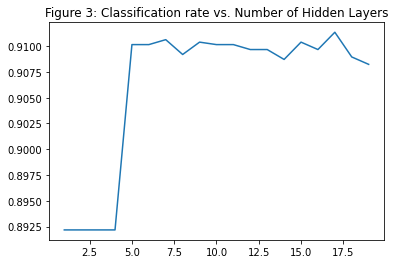

In [ ]:
from sklearn.neural_network import MLPClassifier

X = data[["Length", "Diameter", "Height"]]
X = np.asarray(X)
y = np.asarray(data["ageClass"])

skf = KFold(n_splits=5)

degrees = [i for i in range(1, 20)]
mses = []

for d in degrees:
    kmses = []
    for train_index, test_index in skf.split(X):
        trainX, valX = X[train_index], X[test_index]
        trainY, valY = y[train_index], y[test_index]
        
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=1000,
                        hidden_layer_sizes=(d,), random_state=1)

        clf.fit(trainX, trainY)
        predict = clf.score(valX, valY)
        kmses.append(predict)
    
    # kmses contains the mse for each split, k. Take the mean of this and append it to mses.
    mses.append(sum(kmses) / len(kmses))

plt.plot(degrees, mses)
plt.title("Figure 3: Classification rate vs. Number of Hidden Layers")

Here we see 17 nodes seems to have the best performance, though 7 is about as good and far simpler. Again, this is not representative of how one should go about considering proper architecture for a neural network, but just a jumping off point for further exploration. 

## Conclusion

Sklearn is one of the most important libraries for any data scientist to know alongside pandas, humble numpy, and pytorch. Its extensive library of cross-validation methods is particularly appealing, and it's also great for some of the simpler modelling, from linear regression to neural networks. 

From this tutorial, hopefully the reader will have a solid understanding of what cross-validation is in its simplest form of holdout validation (if they didn't already), and more importanly, know when bread-and-butter k-fold validation isn't enough. Further, this will have exposed the reader to sklearn's intuitive linear regression kNN, and neural net modelling capabilities, with code included to perform cross-validation on each. The neural network, as a caveat, definitely requires more extensive fine-tuning, but hopefully introducing it will serve as a jumping off point to further exploration of it as a modelling tool. Further, the code provided will serve for a plethora of other common modelling tools that sklearn provides, whether one replaces linear regression with splines or kNN with a decision tree.

Sources:
- Cross-validation Techniques: https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
- LOOCV: https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/#:~:text=The%20Leave%2DOne%2DOut%20Cross,used%20to%20train%20the%20model.
- Abalone Dataset: https://archive.ics.uci.edu/ml/datasets/Abalone
- Neural Network Tuning: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw